## LDA Model Visualization and Subject Analysis

In [144]:
#import necessary packages
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import re
import datetime
from dateutil.relativedelta import relativedelta
from datetime import date
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
#import necessary packages for further word processing
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2020)
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /global/homes/d/dsmorrow/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
#function to perform lemmatize and stem preprocessing steps on the data set.
def lemmatize_stemming(text):
    stemmer = PorterStemmer()
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2:
            result.append(lemmatize_stemming(token))
    return result

In [4]:
#load in csv with pre=preprocessing already done on the text (lowercasing, etc.)
full_proc = pd.read_csv("Full_Table_ICD9_Notes.csv", usecols=['SUBJECT_ID',"CATEGORY",'text_processed', "index"])
full_proc

,SUBJECT_ID,CATEGORY,text_processed,index
0,109,Discharge summary,admission date 2142 5 15 discharge date 2142 5...,0
1,109,Discharge summary,admission date 2142 5 20 discharge date 2142 6...,1
2,109,Discharge summary,admission date 2142 6 18 discharge date 2142 6...,2
3,109,Discharge summary,admission date 2142 7 3 discharge date 2142 7 ...,3
4,109,Discharge summary,admission date 2142 7 7 discharge date 2142 7 ...,4
...,...,...,...,...
323055,65504,Radiology,last name lf first name3 lf 1046 j last name ...,323055
323056,65504,Radiology,2143 9 3 9 59 am chest pa lat clip clip numbe...,323056
323057,65504,Radiology,2144 2 25 1 49 pm ankle ap mortise lat left c...,323057
323058,65504,Radiology,2144 1 7 4 21 pm ankle ap mortise lat left cl...,323058


Selecting a subject ID from the 'full_proc' dataframe allows us to see how the LDA model can identify topics within certain documents.
Specifically, if we look at the potential topics for a subject, we can infer whether or not they are at higher risk of suicide
Lets see how well this LDA Model worked when we look at a subject within the training group

In [145]:
#select only for subject 109 from the DoD group
subject_1 = full_proc.loc[full_proc['SUBJECT_ID'] == 109]

In [6]:
subject_109 = subject_1

In [7]:
#complete preprocesseding on text to stem and lemmatize
subject_109_docs = subject_109['text_processed'].map(preprocess)

In [8]:
subject_109_docs

0       [admiss, date, discharg, date, date, birth, se...
1       [admiss, date, discharg, date, date, birth, se...
2       [admiss, date, discharg, date, date, birth, se...
3       [admiss, date, discharg, date, date, birth, se...
4       [admiss, date, discharg, date, date, birth, se...
                              ...                        
1212    [chief, complaint, hour, event, sbp, overnight...
1213    [chief, complaint, hour, event, dialysi, cathe...
1214    [chief, complaint, saw, examin, patient, physi...
1215    [chief, complaint, saw, examin, patient, physi...
1216    [titl, chief, complaint, new, onset, seizur, h...
Name: text_processed, Length: 1217, dtype: object

In [9]:
#create dictionary of words
dictionary_109 = gensim.corpora.Dictionary(subject_109_docs)
count = 0
for k, v in dictionary_109.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 abdomen
1 abdomin
2 abl
3 abnorm
4 abus
5 accid
6 acut
7 admiss
8 admit
9 afebril
10 age


In [10]:
#filter out words that appear in less than (8) documents
#only keep the first 10000
dictionary_109.filter_extremes(no_below=8, no_above=0.5, keep_n=100000)

In [11]:
#convert dictionary to BOW for LDA model to process
bow_corpus_109 = [dictionary_109.doc2bow(doc) for doc in subject_109_docs]

In [12]:
#determine the TF-IDF scores or weight of a word within a document
from gensim import corpora, models
tfidf_109 = models.TfidfModel(bow_corpus_109)
corpus_tfidf_109 = tfidf_109[bow_corpus_109]

In [ ]:
#process full text for all subject for visualization 

In [13]:
#change variable for LDA modeling
documents = full_proc

In [14]:
#use preprocess function on all notes and subjects
processed_docs = documents['text_processed'].map(preprocess)

In [15]:
#create dictionary of words and number of appearances 
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 abdomen
1 abdomin
2 abl
3 abnorm
4 abus
5 accid
6 acut
7 admiss
8 admit
9 afebril
10 age


In [16]:
#filter out words that appear in less than (15) documents
#only keep the first 10000
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [17]:
#go through each document and report words and occurrences using doc2box for token id and amount
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [18]:
#determine the TF-IDF scores or weight of a word within the documents
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [19]:
#train LDA model using BOW, chunk size is 5000 documents, lda is updated after every chunk size, 2 full passes through the corpus for training, produce 10 topics
lda_model = gensim.models.ldamodel.LdaModel(corpus=bow_corpus,
                                           id2word=dictionary,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=5000,
                                           passes=2)

In [20]:
#train LDA model using TFIDF corpus, chunk size is 5000 documents, lda is updated after every chunk size, 2 full passes through the corpus for training, produce 10 topics
lda_model2 = gensim.models.ldamodel.LdaModel(corpus=corpus_tfidf,
                                           id2word=dictionary,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=5000,
                                           passes=2)

In [21]:
#create function to create end up with dataframe that includes, the document index, the dominant topic for that document based on the trained LDA model, The percentage of matching, the top weighted words for that topic, and the text of the document
def format_topics_sentences(ldamodel=None, corpus=None, texts=None):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=bow_corpus_109, texts=subject_109_docs)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,6.0,0.5759,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."
1,1,6.0,0.4761,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."
2,2,6.0,0.5524,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."
3,3,6.0,0.5304,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."
4,4,6.0,0.4558,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."
5,5,6.0,0.4935,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."
6,6,6.0,0.5555,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."
7,7,6.0,0.4966,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."
8,8,6.0,0.4333,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."
9,9,6.0,0.4394,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."


In [22]:
#see individually how many documents correlate to a dominant topic
df_dominant_topic.groupby('Dominant_Topic').size()

Dominant_Topic
0.0        2
1.0        2
2.0       50
3.0       24
4.0       39
6.0     1040
8.0       10
9.0       13
10.0       6
11.0       3
12.0       5
13.0       3
16.0       4
17.0       3
18.0       1
19.0      12
dtype: int64

In [ ]:
#subject 109 of DoD has a dominant topic from almost all potential topics

In [137]:
#create funcs and visualization for word count and weight of top words for each topic
from collections import Counter
topics = lda_model.show_topics(formatted=False, num_topics=20)
data_flat = [w for w_list in processed_docs for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

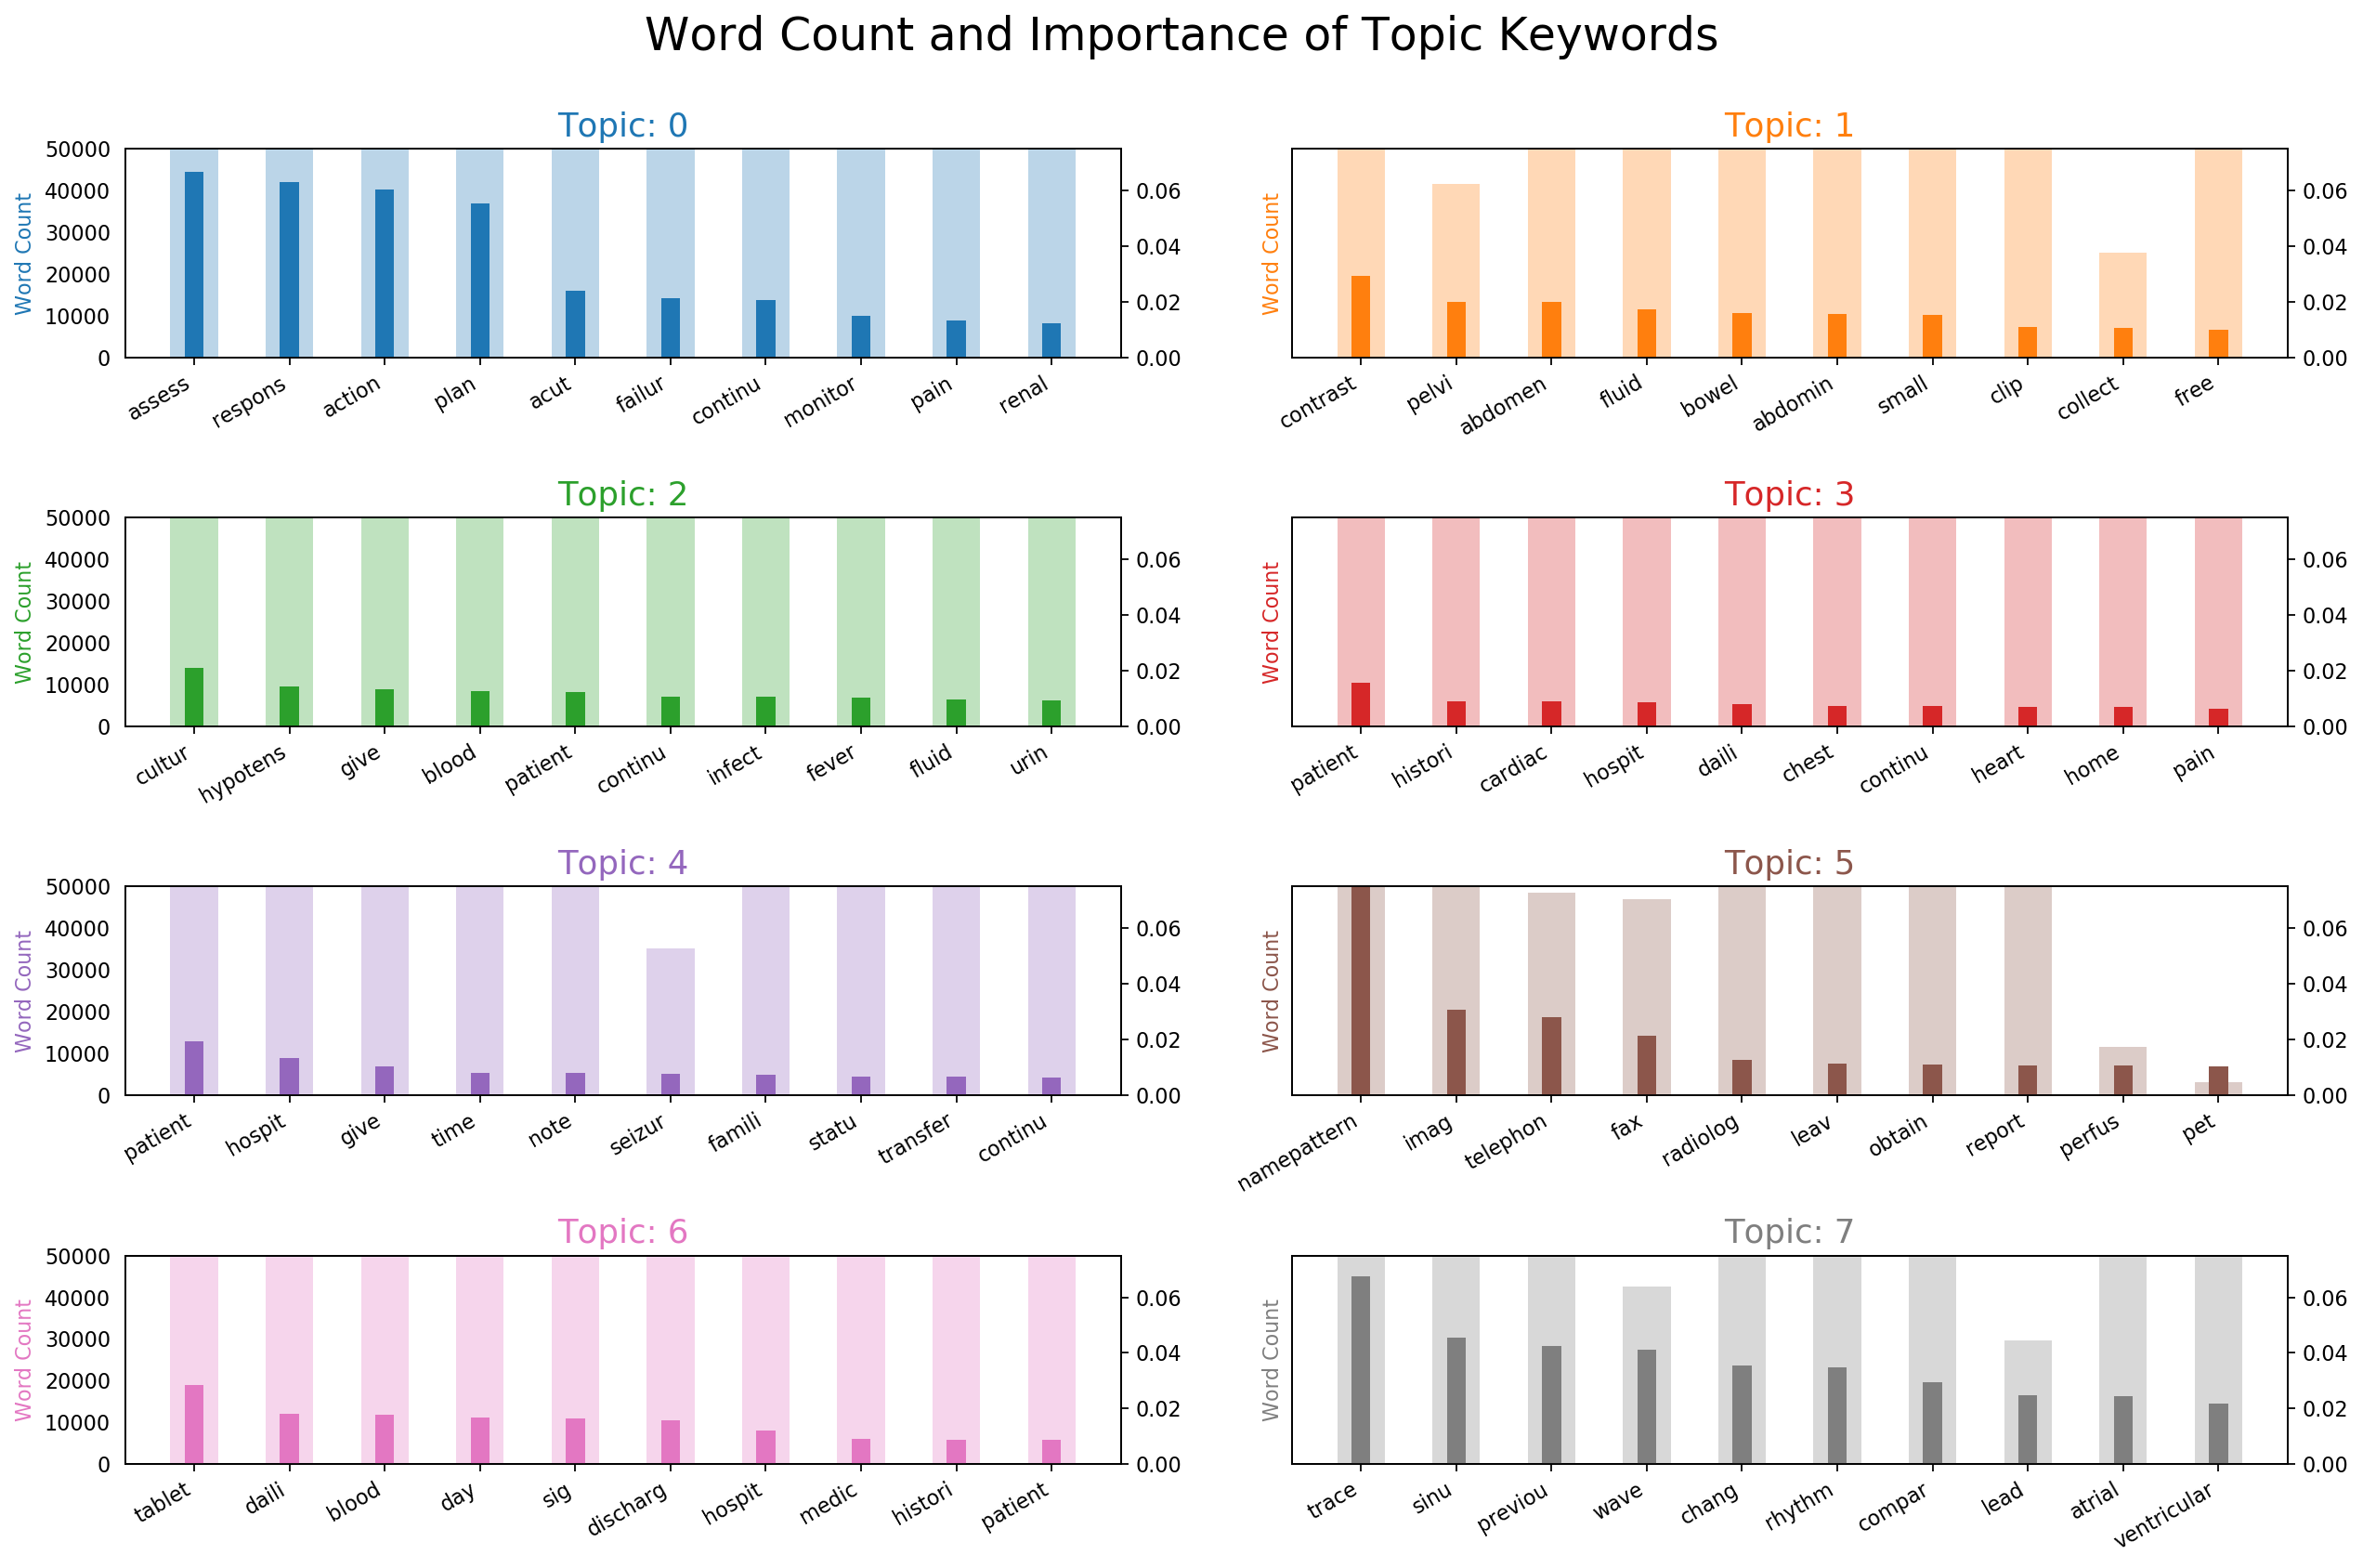

In [142]:
# Plot Word Count and Weights of Topic Keywords by topics from LDA model
fig, axes = plt.subplots(4, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.075); ax.set_ylim(0, 50000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

This visualization looks at each topic configured from the LDA training, and plots the top weighted words along with their word frequency

In [25]:
#sorted and appending topics and percentages of the LDA topics
def topics_per_document(model, corpus):
    corpus_sel = corpus[0:-1]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

#looking at just subject 109 from DoD; preprocessing done at the beginning of the notebook
dominant_topics, topic_percentages = topics_per_document(lda_model, bow_corpus_109)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

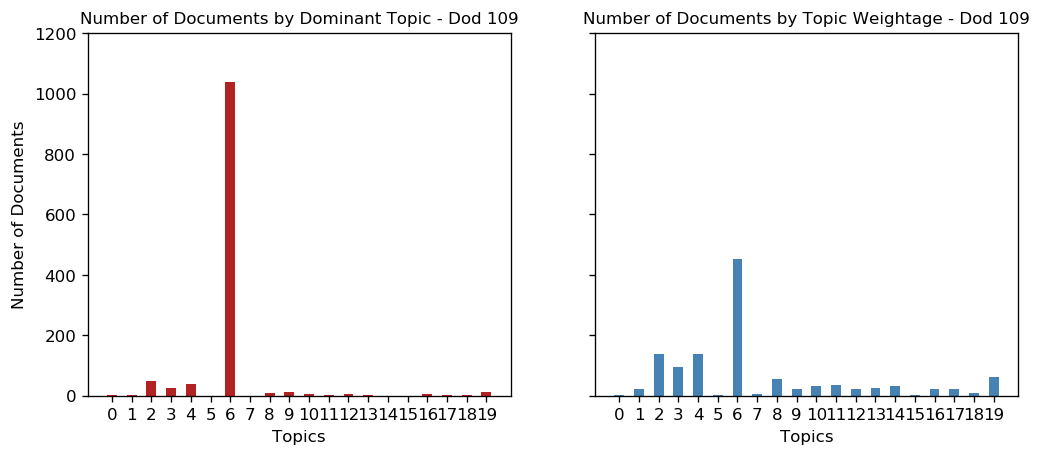

In [82]:
#topic weightage is the sum of all documents that have a weight for that topic

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(0,20))
ax1.set_title('Number of Documents by Dominant Topic - Dod 109', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1200)
ax1.set_xlabel('Topics')

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.set_title('Number of Documents by Topic Weightage - Dod 109', fontdict=dict(size=10))
ax2.set_xlabel('Topics')

plt.show()

Back to subject 109:
Based on this subjects documents, they have a probability of falling under almost of the LDA topics
Topic 6 is where the majority of documents have a probability of falling under

In [27]:
#reread in csv so that i can select for only suicide attempt subjects instead of DoD
dateparse = lambda dates: [pd.datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in dates]
diagnosis_icd9 = pd.read_csv("/project/projectdirs/m1532/Projects_MVP/_datasets/mimiciii/DIAGNOSES_ICD.csv", usecols= ["SUBJECT_ID", "ICD9_CODE"])
patients = pd.read_csv("/project/projectdirs/m1532/Projects_MVP/_datasets/mimiciii/PATIENTS.csv", parse_dates= ["DOB"], date_parser=dateparse, usecols=["SUBJECT_ID", "DOB"])
admissions = pd.read_csv("/project/projectdirs/m1532/Projects_MVP/_datasets/mimiciii/ADMISSIONS.csv", parse_dates= ["ADMITTIME"], date_parser=dateparse, usecols=["SUBJECT_ID", "ADMITTIME"])
notes = pd.read_csv("/project/projectdirs/m1532/Projects_MVP/_datasets/mimiciii/NOTEEVENTS.csv", usecols = ['SUBJECT_ID','CATEGORY', 'TEXT'])

In [28]:
#filter for only suicide attempts ICD9 codes
diag_suicide_DF = diagnosis_icd9[diagnosis_icd9["ICD9_CODE"].str.startswith(('E95'), na = False)]
diag_suicide_DF.head()

,SUBJECT_ID,ICD9_CODE
102,119,E956
350,71,E9503
760,22,E9502
761,22,E9503
2036,303,E9500


In [29]:
#merge suicide dataframe with notes
icd9_suicide = pd.merge(diag_suicide_DF, notes, on ='SUBJECT_ID')
icd9_suicide

,SUBJECT_ID,ICD9_CODE,CATEGORY,TEXT
0,119,E956,ECG,Sinus rhythm\nHigh QRS voltage - probable norm...
1,119,E956,ECG,"Normal sinus rhythm, rate 94\nNonspecific ante..."
2,119,E956,Radiology,[**2159-9-12**] 6:44 AM\n WRIST(3 + VIEWS) LEF...
3,119,E956,Radiology,[**2159-9-12**] 6:46 AM\n CHEST (PRE-OP AP ONL...
4,119,E956,Nursing/other,"awake,alert, and oriented x3. pt is calm and c..."
...,...,...,...,...
23020,97625,E9500,Radiology,[**2105-2-17**] 7:17 AM\n CHEST (PORTABLE AP) ...
23021,97625,E9500,Radiology,[**2105-2-16**] 12:08 AM\n CHEST (PORTABLE AP)...
23022,97625,E9500,Physician,TITLE:\n Chief Complaint: acute hepatic inj...
23023,97625,E9500,Physician,TITLE:\n Chief Complaint: acute hepatic inj...


In [30]:
#bring in the admittime column from separate csv
icd9_suicide = pd.merge(icd9_suicide, admissions, on="SUBJECT_ID")
icd9_suicide.head()

,SUBJECT_ID,ICD9_CODE,CATEGORY,TEXT,ADMITTIME
0,119,E956,ECG,Sinus rhythm\nHigh QRS voltage - probable norm...,2159-09-12 15:26:00
1,119,E956,ECG,"Normal sinus rhythm, rate 94\nNonspecific ante...",2159-09-12 15:26:00
2,119,E956,Radiology,[**2159-9-12**] 6:44 AM\n WRIST(3 + VIEWS) LEF...,2159-09-12 15:26:00
3,119,E956,Radiology,[**2159-9-12**] 6:46 AM\n CHEST (PRE-OP AP ONL...,2159-09-12 15:26:00
4,119,E956,Nursing/other,"awake,alert, and oriented x3. pt is calm and c...",2159-09-12 15:26:00


In [31]:
#pre-preprocess these notes
# Remove punctuation and anything that isnt a character or number 
icd9_suicide['text_processed'] = icd9_suicide['TEXT'].map(lambda x: re.sub('[_\\W]+', ' ', x))
# Convert to lowercase
icd9_suicide['text_processed'] = icd9_suicide['text_processed'].map(lambda x: x.lower())
icd9_suicide

,SUBJECT_ID,ICD9_CODE,CATEGORY,TEXT,ADMITTIME,text_processed
0,119,E956,ECG,Sinus rhythm\nHigh QRS voltage - probable norm...,2159-09-12 15:26:00,sinus rhythm high qrs voltage probable normal ...
1,119,E956,ECG,"Normal sinus rhythm, rate 94\nNonspecific ante...",2159-09-12 15:26:00,normal sinus rhythm rate 94 nonspecific antero...
2,119,E956,Radiology,[**2159-9-12**] 6:44 AM\n WRIST(3 + VIEWS) LEF...,2159-09-12 15:26:00,2159 9 12 6 44 am wrist 3 views left port cli...
3,119,E956,Radiology,[**2159-9-12**] 6:46 AM\n CHEST (PRE-OP AP ONL...,2159-09-12 15:26:00,2159 9 12 6 46 am chest pre op ap only port c...
4,119,E956,Nursing/other,"awake,alert, and oriented x3. pt is calm and c...",2159-09-12 15:26:00,awake alert and oriented x3 pt is calm and coo...
...,...,...,...,...,...,...
42548,97625,E9500,Radiology,[**2105-2-17**] 7:17 AM\n CHEST (PORTABLE AP) ...,2105-02-15 18:00:00,2105 2 17 7 17 am chest portable ap clip clip...
42549,97625,E9500,Radiology,[**2105-2-16**] 12:08 AM\n CHEST (PORTABLE AP)...,2105-02-15 18:00:00,2105 2 16 12 08 am chest portable ap clip cli...
42550,97625,E9500,Physician,TITLE:\n Chief Complaint: acute hepatic inj...,2105-02-15 18:00:00,title chief complaint acute hepatic injury hpi...
42551,97625,E9500,Physician,TITLE:\n Chief Complaint: acute hepatic inj...,2105-02-15 18:00:00,title chief complaint acute hepatic injury hpi...


In [32]:
#adding additional index column for calling
index = tuple(range(0, 42553, 1))
icd9_suicide["index"] = index

In [89]:
#select only for subject 303 that has attempted suicide
documents_suicide = icd9_suicide.loc[icd9_suicide['SUBJECT_ID'] == 303]

In [90]:
#resetting index because following code for dataframe has trouble identifying text when pulling from middle of dataframe
documents_suicide = documents_suicide.reset_index()

In [91]:
#use preprocess function on suicide attempt subjects
processed_docs_suicide = documents_suicide['text_processed'].map(preprocess)

In [35]:
#create dictionary of words
dictionary_303s = gensim.corpora.Dictionary(processed_docs_suicide)
count = 0
for k, v in dictionary_303s.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 abdomen
1 accid
2 admiss
3 admit
4 allergi
5 ambul
6 birth
7 blood
8 brace
9 brief
10 bring


In [36]:
#filter out words that appear in less than (5) documents - adjusted due to the sig smaller amount of documents for this subject
#only keep the first 10000
dictionary_303s.filter_extremes(no_below=5, no_above=0.5, keep_n=100000)

In [37]:
#go through each document and report words and occurrences using doc2box for token id and amount
bow_corpus_303s = [dictionary_303s.doc2bow(doc) for doc in processed_docs_suicide]

In [38]:
#sorted and appending topics and percentages of the LDA topics (function can be found above)
dominant_topics_303, topic_percentages_303 = topics_per_document(lda_model, bow_corpus_303s)            

# Distribution of Dominant Topics in Each Document
df_303 = pd.DataFrame(dominant_topics_303, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc_303 = df_303.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc_303 = dominant_topic_in_each_doc_303.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc_303 = pd.DataFrame([dict(t) for t in topic_percentages_303])
df_topic_weightage_by_doc_303 = topic_weightage_by_doc_303.sum().to_frame(name='count').reset_index()

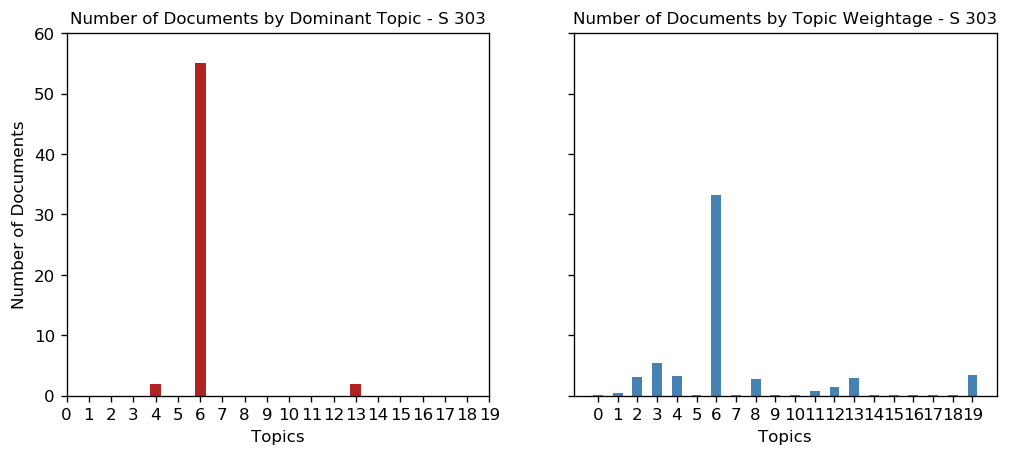

In [86]:
# Plot for subject 303 comparing document topics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc_303, width=.5, color='firebrick')
ax1.set_xticks(range(0,20))
ax1.set_title('Number of Documents by Dominant Topic - S 303', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 60)
ax1.set_xlabel('Topics')

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc_303, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc_303.index.unique().__len__()))
ax2.set_title('Number of Documents by Topic Weightage - S 303', fontdict=dict(size=10))
ax2.set_xlabel('Topics')

plt.show()

Suicide attempt subject 303 only has 3 dominant topics that their documents fall under.

In [92]:
#function found above
df_topic_sents_keywords_303 = format_topics_sentences(ldamodel=lda_model, corpus=bow_corpus_303s, texts=processed_docs_suicide)

# Format
df_dominant_topic_303 = df_topic_sents_keywords_303.reset_index()
df_dominant_topic_303.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic_303.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,6.0,0.5573,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."
1,1,6.0,0.5573,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."
2,2,6.0,0.4404,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."
3,3,6.0,0.4383,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."
4,4,13.0,0.6833,"procedur, right, vein, leav, cathet, arteri, c...","[sinu, rhythm, normal, ecg, age]"
5,5,13.0,0.6833,"procedur, right, vein, leav, cathet, arteri, c...","[sinu, rhythm, normal, ecg, age]"
6,6,6.0,0.5213,"tablet, daili, blood, day, sig, discharg, hosp...","[sinu, rhythm, slight, non, specif, inferior, ..."
7,7,6.0,0.5214,"tablet, daili, blood, day, sig, discharg, hosp...","[sinu, rhythm, slight, non, specif, inferior, ..."
8,8,6.0,0.4549,"tablet, daili, blood, day, sig, discharg, hosp...","[trauma, seri, lat, spine, cxr, pelvi, port, c..."
9,9,6.0,0.4555,"tablet, daili, blood, day, sig, discharg, hosp...","[trauma, seri, lat, spine, cxr, pelvi, port, c..."


In [93]:
#how many documents for each dominant topic
df_dominant_topic_303.groupby('Dominant_Topic').size()

Dominant_Topic
4.0      2
6.0     56
13.0     2
dtype: int64

In [94]:
#continued evaluation of a different subject who has attempted suicide
documents_suicide_95136 = icd9_suicide.loc[icd9_suicide['SUBJECT_ID'] == 95136]

In [96]:
#reset index
documents_suicide_95136 = documents_suicide_95136.reset_index()

In [100]:
#use preprocess function on suicide attempt subject 95136
processed_docs_suicide_95 = documents_suicide_95136['text_processed'].map(preprocess)

In [101]:
#create dictionary of words
dictionary_95136s = gensim.corpora.Dictionary(processed_docs_suicide_95)

In [102]:
#filter out words that appear in less than (15) documents
#only keep the first 10000
dictionary_95136s.filter_extremes(no_below=5, no_above=0.5, keep_n=100000)

In [103]:
#go through each document and report words and occurrences using doc2box for token id and amount
bow_corpus_95136 = [dictionary_95136s.doc2bow(doc) for doc in processed_docs_suicide_95]

In [104]:
#sorted and appending topics and percentages of the LDA topics
dominant_topics_95, topic_percentages_95 = topics_per_document(lda_model, bow_corpus_95136)            

# Distribution of Dominant Topics in Each Document
df_95 = pd.DataFrame(dominant_topics_95, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc_95 = df_95.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc_95 = dominant_topic_in_each_doc_95.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc_95 = pd.DataFrame([dict(t) for t in topic_percentages_95])
df_topic_weightage_by_doc_95 = topic_weightage_by_doc_95.sum().to_frame(name='count').reset_index()

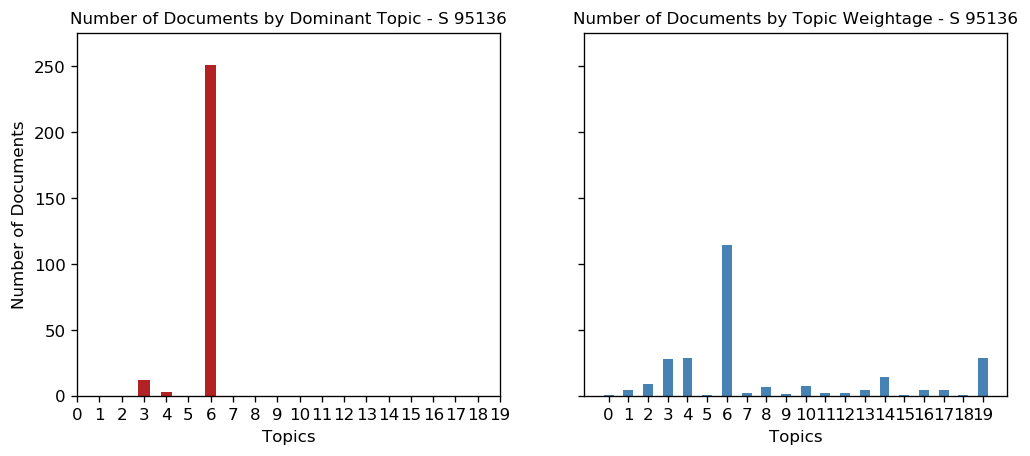

In [108]:
# Plot subject 95136 comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc_95, width=.5, color='firebrick')
ax1.set_xticks(range(0,20))
ax1.set_title('Number of Documents by Dominant Topic - S 95136', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 275)
ax1.set_xlabel('Topics')

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc_95, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc_95.index.unique().__len__()))
ax2.set_title('Number of Documents by Topic Weightage - S 95136', fontdict=dict(size=10))
ax2.set_xlabel('Topics') 

plt.show()

In [109]:
df_topic_sents_keywords_95 = format_topics_sentences(ldamodel=lda_model, corpus=bow_corpus_95136, texts=processed_docs_suicide_95)

# Format
df_dominant_topic_95 = df_topic_sents_keywords_95.reset_index()
df_dominant_topic_95.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic_95.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,6.0,0.5127,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."
1,1,6.0,0.5127,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."
2,2,6.0,0.5127,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."
3,3,6.0,0.4717,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."
4,4,6.0,0.4717,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."
5,5,6.0,0.4717,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."
6,6,6.0,0.4551,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."
7,7,6.0,0.4551,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."
8,8,6.0,0.4551,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."
9,9,6.0,0.4572,"tablet, daili, blood, day, sig, discharg, hosp...","[patient, test, inform, indic, herceptin, rece..."


In [143]:
#how many document per dominant?
df_dominant_topic_95.groupby('Dominant_Topic').size()

Dominant_Topic
3.0     12
4.0      3
6.0    252
dtype: int64

In [57]:
# subject 523 of suicide attempts
documents_suicide_523 = icd9_suicide.loc[icd9_suicide['SUBJECT_ID'] == 523]

In [110]:
documents_suicide_523 = documents_suicide_523.reset_index()

In [71]:
#use preprocess function on suicide attempt subjects
processed_docs_suicide_523 = documents_suicide_523['text_processed'].map(preprocess)

In [61]:
#create dictionary of words
dictionary_523 = gensim.corpora.Dictionary(processed_docs_suicide_523)

In [62]:
#filter out words that appear in less than (5) documents
#only keep the first 10000
dictionary_523.filter_extremes(no_below=5, no_above=0.5, keep_n=100000)

In [63]:
#go through each document and report words and occurrences using doc2box for token id and amount
bow_corpus_523 = [dictionary_523.doc2bow(doc) for doc in processed_docs_suicide_523]

In [73]:
df_topic_sents_keywords_523 = format_topics_sentences(ldamodel=lda_model, corpus=bow_corpus_523, texts=processed_docs_suicide_523)

# Format
df_dominant_topic_523 = df_topic_sents_keywords_523.reset_index()
df_dominant_topic_523.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic_523.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,6.0,0.6204,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."
1,1,6.0,0.6204,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."
2,2,6.0,0.6355,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."
3,3,6.0,0.6355,"tablet, daili, blood, day, sig, discharg, hosp...","[admiss, date, discharg, date, date, birth, se..."
4,4,3.0,0.3337,"patient, histori, cardiac, hospit, daili, ches...","[patient, test, inform, indic, hypertens, leav..."
5,5,3.0,0.3337,"patient, histori, cardiac, hospit, daili, ches...","[patient, test, inform, indic, hypertens, leav..."
6,6,6.0,0.3768,"tablet, daili, blood, day, sig, discharg, hosp...","[artifact, present, sinu, rhythm, normal, trac..."
7,7,6.0,0.3758,"tablet, daili, blood, day, sig, discharg, hosp...","[artifact, present, sinu, rhythm, normal, trac..."
8,8,6.0,0.7778,"tablet, daili, blood, day, sig, discharg, hosp...","[sinu, arrhythmia, tall, peak, wave, rightward..."
9,9,6.0,0.7805,"tablet, daili, blood, day, sig, discharg, hosp...","[sinu, arrhythmia, tall, peak, wave, rightward..."


In [74]:
#sorted and appending topics and percentages of the LDA topics
dominant_topics_523, topic_percentages_523 = topics_per_document(lda_model, bow_corpus_523)            

# Distribution of Dominant Topics in Each Document
df_523 = pd.DataFrame(dominant_topics_523, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc_523 = df_523.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc_523 = dominant_topic_in_each_doc_523.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc_523 = pd.DataFrame([dict(t) for t in topic_percentages_523])
df_topic_weightage_by_doc_523 = topic_weightage_by_doc_523.sum().to_frame(name='count').reset_index()

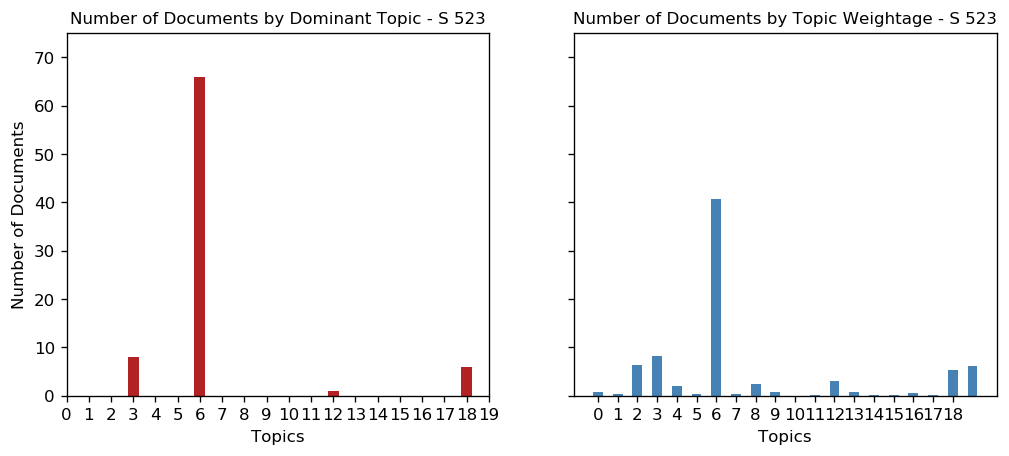

In [113]:
# Plot for subject 523 comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc_523, width=.5, color='firebrick')
ax1.set_xticks(range(0,20))
ax1.set_title('Number of Documents by Dominant Topic - S 523', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 75)
ax1.set_xlabel('Topics')

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc_523, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc_523.index.unique().__len__()))
ax2.set_title('Number of Documents by Topic Weightage - S 523', fontdict=dict(size=10))
ax2.set_xlabel('Topics')

plt.show()

Results so far:
All three suicide attempt subjects ranked Topic 6 as their most dominant topic for all of their documents 
Additionally, each subject only had 3 or 4 dominant topics (probability highest among all potential)
Whereas, the DoD subject has almost all 20 dominant topics for their documents (which makes sense because they are from the training data)
DoD subject also ranked Topic 6 as having the most documents under this topic.
Is Topic 6 the best identifier of high risk patients?

In [146]:
#use preprocess function on entire documents for suicide attempt
s_proc_docs = icd9_suicide['text_processed'].map(preprocess)

In [147]:
#create dictionary of words and number of appearances 
s_dictionary = gensim.corpora.Dictionary(s_proc_docs)

In [148]:
#filter out words that appear in less than (15) documents
#only keep the first 10000
s_dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [149]:
#go through each document and report words and occurrences using doc2box for token id and amount
s_bow_corpus = [s_dictionary.doc2bow(doc) for doc in s_proc_docs]

In [150]:
#sorted and appending topics and percentages of the LDA topics (function can be found above)
dominant_topics_s, topic_percentages_s = topics_per_document(lda_model, s_bow_corpus)            

# Distribution of Dominant Topics in Each Document
df_s = pd.DataFrame(dominant_topics_s, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc_s = df_s.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc_s = dominant_topic_in_each_doc_s.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc_s = pd.DataFrame([dict(t) for t in topic_percentages_s])
df_topic_weightage_by_doc_s = topic_weightage_by_doc_s.sum().to_frame(name='count').reset_index()

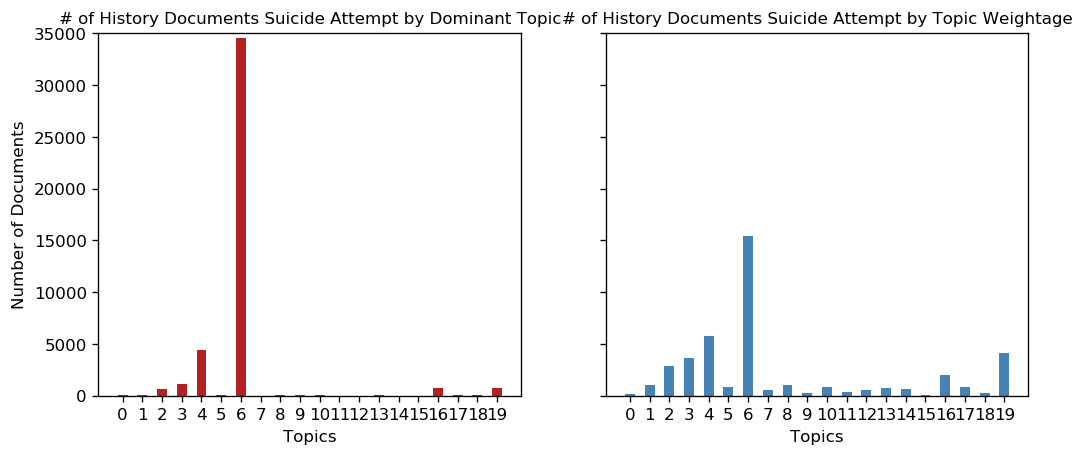

In [158]:
# Plot for comparing document topics from suicide attempts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc_s, width=.5, color='firebrick')
ax1.set_xticks(range(0,20))
ax1.set_title('# of History Documents Suicide Attempt by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 35000)
ax1.set_xlabel('Topics')

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc_s, width=.5, color='steelblue')
ax2.set_xticks(range(0,20))
ax2.set_title('# of History Documents Suicide Attempt by Topic Weightage', fontdict=dict(size=10))
ax2.set_xlabel('Topics')

plt.show()

In [153]:
df_topic_sents_keywords_s = format_topics_sentences(ldamodel=lda_model, corpus=s_bow_corpus, texts=s_proc_docs)

# Format
df_dominant_topic_s = df_topic_sents_keywords_s.reset_index()
df_dominant_topic_s.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [154]:
#what is the min and max probability for matching a topic?
df_dominant_topic_s['Topic_Perc_Contrib'].describe()

count    42553.000000
mean         0.417001
std          0.124246
min          0.050000
25%          0.327800
50%          0.394000
75%          0.490600
max          0.947100
Name: Topic_Perc_Contrib, dtype: float64

In [156]:
df_dominant_topic_s.groupby('Dominant_Topic').size()

Dominant_Topic
0.0        20
1.0        89
2.0       612
3.0      1094
4.0      4377
5.0       103
6.0     34522
7.0         1
8.0        67
9.0        27
10.0       44
11.0        1
12.0       14
13.0       17
14.0       17
15.0        1
16.0      697
17.0       64
18.0       30
19.0      756
dtype: int64

Overall Suicide attempt documents as a whole:
Document 6 is the dominant topic. 
The average probability for a document belonging to a topic is 0.42, with a max of 0.95

In [ ]:
##lets look at 1 or 2 diabetes patients and see how many dominant topics and weightage ranks up 